In [2]:
import os

import pickle
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy_indexed as npi
from scipy.io import loadmat

from src.ipm import NeuronLoader, grablabels

# from imblearn.under_sampling import RandomUnderSampler as rus
from scipy.ndimage import gaussian_filter1d as smooth

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split as tts

# Loading the Neural Dataset

In [3]:
data = NeuronLoader('G:/Data/Fast/Jenab')

with open("./src/info.pkl", "rb") as handler:
    info = pickle.load(handler)
info = info[:165]

## Neuron Selection based on Visual Drive

In [4]:
def visual_drive(time, neuron):
    gray   = neuron[:, time < 0].mean(1)
    images = neuron[:, (time > 0) & (time < 200)].mean(1)
    sigma_images = images.std()
    sigma_gray   = gray.std()

    dprime = (images.mean() - gray.mean()) / np.sqrt(0.5 * (sigma_gray ** 2 + sigma_images ** 2))
    return dprime

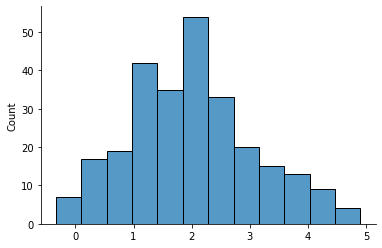

In [5]:
vd = []
for iit in range(data.it.shape[1]):
    vd.append(visual_drive(data.time, data.it[:, iit, :]))

sns.histplot(vd)
sns.despine()

vd_idx = np.array(vd) > 0.6

## Neuron Selection based on Rank-Order Response Reliability

In [6]:
split1 = np.load('G:/Data/Fast/Jenab/itc-half-split-1.npy')
split2 = np.load('G:/Data/Fast/Jenab/itc-half-split-2.npy')

In [7]:
r, p = pearsonr(split1[:, (time > 0) & (time < 200)].mean(1), 
         neuron_s2[:, (time > 0) & (time < 200)].mean(1))
shtr = 2 * r / (1 + r)

NameError: name 'neuron_s1' is not defined

array must not contain infs or NaNs


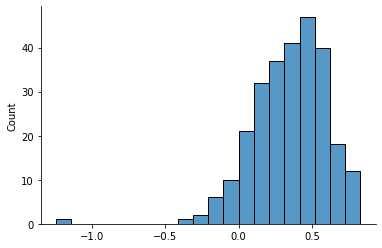

In [8]:
from scipy.stats import pearsonr

time = np.arange(-200, 700)

reliability = []
for iit in range(split1.shape[1]):
    try:
        neuron_s1, neuron_s2 = split1[:, iit, :], split2[:, iit, :]
        
        # r1 = neuron_s1[:, (time) & ()]
        # r, p = pearsonr(neuron_s1.flatten(), neuron_s2.flatten())
        r, p = pearsonr(neuron_s1[:, (time > 50) & (time < 150)].mean(1), 
                        neuron_s2[:, (time > 50) & (time < 150)].mean(1))
        shtr = 2 * r / (1 + r)
    except Exception as e:
        print(e)
        shtr = 0
    reliability.append(shtr)

sns.histplot(reliability)
sns.despine()

In [9]:
ir_idx = np.array(reliability) > 0.4

In [10]:
(ir_idx & vd_idx).sum()

121

In [135]:
def movavg(inp, bl, ss):
    nbin = int(np.floor((inp.shape[2] - bl) / ss))
    out = np.nan * np.zeros((inp.shape[0], inp.shape[1], nbin))
    for ibin in range(nbin):
        out[:, :, ibin] = np.sum(inp[:, :, int(ibin*ss):int(ibin*ss)+bl], 2) / bl * 1000
    return out

In [140]:
it_pool = data.it[:, ir_idx & vd_idx, :]

# Regression

In [141]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

r = []
for ipfc in tqdm(range(data.pfc.shape[1])):
    r2 = []
    for ibin in range(data.it.shape[2]):
        target = data.pfc[:, ipfc, ibin]
        regressor = it_pool[:, :, ibin]

        pred, targ = [], []
        kf = KFold(n_splits=5, shuffle=True, random_state=0)
        for train_idx, test_idx in kf.split(regressor):
            X_train, X_test = regressor[train_idx], regressor[test_idx]
            y_train, y_test = target[train_idx], target[test_idx]

            mdl = Ridge(alpha=1.0, fit_intercept=True, random_state=0, solver='lsqr')
            mdl.fit(X_train, y_train)

            pred.extend(mdl.predict(X_test))
            targ.extend(y_test)
        r2.append(r2_score(targ, pred))
    r.append(r2)

r = np.array(r)

  0%|          | 0/209 [00:00<?, ?it/s]

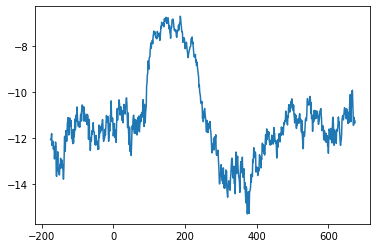

In [142]:
plt.plot(data.time, r.mean(0));

In [42]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

r = []
for ipfc in tqdm(range(data.pfc.shape[1])):
    r2 = []
    for ibin in range(data.it.shape[2]):
        target = data.pfc[:, ipfc, ibin]
        regressor = data.it[:, :, ibin-1]

        pred, targ = [], []
        kf = KFold(n_splits=5, shuffle=True, random_state=0)
        for train_idx, test_idx in kf.split(regressor):
            X_train, X_test = regressor[train_idx], regressor[test_idx]
            y_train, y_test = target[train_idx], target[test_idx]

            mdl = Ridge(alpha=1.0, fit_intercept=True, random_state=0, solver='lsqr')
            mdl.fit(X_train, y_train)

            pred.extend(mdl.predict(X_test))
            targ.extend(y_test)
        r2.append(r2_score(targ, pred))
    r.append(r2)

r = np.array(r)

  0%|          | 0/209 [00:00<?, ?it/s]

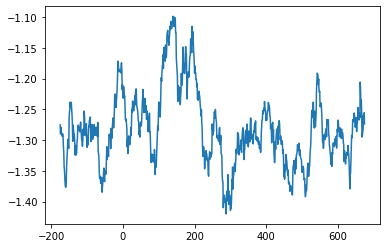

In [44]:
plt.plot(data.time, r.mean(0));